# Implementing a Neural Network with Numpy
### Erkin Polat

In this notebook, I will implement a neural network from scratch by using only numpy. I will also provide comments and explanations to walk you through some of the decisions I made.

In [ ]:
#Out only imports before we load the data
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

What do we need in a neural network?
- neurons
- layers
- activation functions
- weights
- bias
- loss function
- forward propogation
- backpropogation

These are the components that need to be included. I'll first start with the activation functions.

For my activation functions, I coded a lot of them here that could be useful. However, for this implementations we don't really need all of them so I added derivatives for sigmoid only (The derivative of softmax is hard coded in the backpropogation). In this seperate doc I noted down why we might want to choose some of them over others: https://docs.google.com/document/d/1wKTCJ56l_ZT7sRvzn2I4lDXxmFPRicJfxPWHNMef9RY/edit

Therefore, keep in mind that in the network you can only choose sigmoid for the hidden layers and softmax for the output layer. 

Sigmoid:

Advantages
- Smooth gradient, preventing “jumps” in output values.
- Output values bound between 0 and 1, normalizing the output of each neuron.
- Clear predictions—For X above 2 or below -2, tends to bring the Y value (the prediction) to the edge of the curve, very close to 1 or 0. This enables clear predictions.

Disadvantages
- Vanishing gradient—for very high or very low values of X, there is almost no change to the prediction, causing a vanishing gradient problem. This can result in the network refusing to learn further, or being too slow to reach an accurate prediction.
- Outputs not zero centered.
- Computationally expensive

Softmax:

- Able to handle multiple classes only one class in other activation functions—normalizes the outputs for each class between 0 and 1, and divides by their sum, giving the probability of the input value being in a specific class.
- Useful for output neurons—typically Softmax is used only for the output layer, for neural networks that need to classify inputs into multiple categories.
- When combined with cross entropy loss, it is extremely easy to compute the derivative of the loss function. (It's literally y_predictions - y_actual)



In [ ]:
#Different activation functions. They take values or matrices as inputs and return the result when the activation function is applied
def sigmoid(val, derivative=False):
  if derivative:
    return sigmoid(val, derivative=False)* (1-sigmoid(val, derivative=False))
  else:
    return 1/(1+np.e**(-val))

def sinh(val):
  return (1-np.e**(-2*val))/(2*np.e**(-val))

def cosh(val):
  return (1+np.e**(-2*val))/(2*np.e**(-val))

def tanh(val):
  return sinh(val)/cosh(val)

def relu(val):
  return max(0, val)

def leakyrelu(val):
  if val > 0:
    return val
  else:
    return 0.01*val

def softmax(val):
  return np.exp(val - val.max())/np.sum(np.exp(val - val.max()), axis=0)

In [ ]:
#Plotting some of the activation functions. It's nice to see them
def plot_activation(activation_function, function_name):
  #Create a number line for x values
  space = np.linspace(-10, 10, 1000)
  y_vals = []

  #Compute y-values
  for number in space:
    y_vals.append(activation_function(number))
      
  #Plot x and y
  plt.figure(figsize=(4, 3))
  plt.plot(space, y_vals)
  plt.title(function_name)
  plt.show()

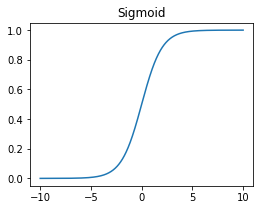

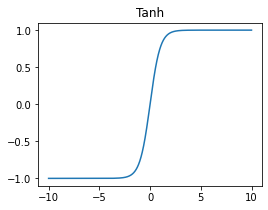

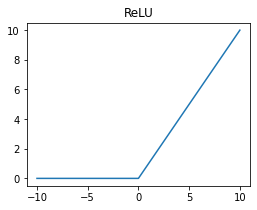

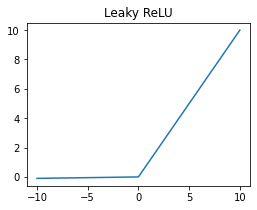

In [ ]:
#Applying the function to the different activation functions we defined
functions = [sigmoid, tanh, relu, leakyrelu]
names = ['Sigmoid', 'Tanh', 'ReLU', 'Leaky ReLU']

for func, name in zip(functions, names):
  plot_activation(func, name)

## Putting together the network.

We will now implement the network by addressing the rest of the points I identified above under 'What do we need in a neural network?'. We will, however, start by thinking about the architecture of the network.

We need to find a coherent architecture that would work. This, indeed, is the most important step up until this stage. We want a network that is adaptable for different problems. We want the users to be able to use different input sizes, different layer sizes, different number of total layers, and we want our network to forward and backpropogate without any issues when the user decides to tweak any of these. Furthermore, we want a standardized notation while defining our classes and methods, so that it is easy for the users to use the network, but at the same time it gives them the chance to extend the model following similar abstractions to what I used. The final product is by no means complete or perfect, however, I tried to address these concerns as much as possible.

I really like the ease of use of the Keras library and therefore I'll try to make my network look similar to the syntax of that. This is also helpful, because I can kind of reverse engineer (this might not be true since Keras is actually an interface for Tensor Flow backend) their model architecture or at least use it as an influence for my own architecture. 

When working with feedforward neural networks in Keras, there is usually a Sequential object that represents the overall network, and the layers reside in it. And all the other models are also instances of different layer classes and are added inside the Sequential model. Fitting and predicting are methods of the Sequential model. Unlike Keras, I don't have/need a compile method for the model at this stage

With these in mind I built a similar architecture. I don't have representations of single nodes. Instead the single smallest component of my network is a layer. There are InputLayer, DenseLayer and Sequential classes, which respectively represent a single input layer, a single dense layer and the whole sequential model. I store everything related to a layer inside that layer instead of outside dictionaries and therefore they can be called very easily. The Sequential class has an "add()" method, which can be used to add any layer instance inside the model. 

In [ ]:
#Different classes used

class InputLayer():
  def __init__(self, input_size):
    '''
    The input layer class. Takes input size as an input. Doesn't store any weights.
    '''
    self.size = input_size
    #Activations. In this case is equal to the input data. Used while backpropogating
    self.A = None


class DenseLayer():
  def __init__(self, nodes, previous, activation_function):
    '''
    Dense layer class. Creates a fully connected layer. 
      nodes - the size of the layer
      previous - the size of the previous layer. Important to initialize the weight matrix
      activation - which activation function will be used
    '''
    self.size = nodes #The number of nodes in the layer
    self.W = np.random.randn(self.size, previous) #Weight matrix. Initialized randomly
    self.b = np.random.randn(self.size, 1) #Bias vector. Initialized randomly
    self.activation = activation_function #the activation function
    self.Z = None #Output of the linear mapping
    self.A = None #Activations of the layer
    self.dW = np.zeros(self.W.shape) #Gradient wrt weights for the layer
    self.db = np.zeros(self.b.shape) #Gradient wrt biases for the layer

  def forward(self, input):
    '''
    Function to do a single step of the forward propogation
    Args:
      input - Takes the previous activations passed inside the later

    Return:
      A - The activation values
    '''
    #Z is calculated by adding bias to the dot product of weights with the input
    Z = np.matmul(self.W, input) + self.b
    #Saving Z
    self.Z = Z
    #Putting Z in the activation function
    A = self.activation(Z)
    #Saving A
    self.A = A
    return A

class Sequential():
  def __init__(self, learning_rate=0.01):
    '''
    Class for the model as a whole. Performs forward and backpropogation, fitting and prediction.
      learning_rate - the learning rate used for updating the weights. Defaulted to 0.01
    '''
    self.layers = [] #List to hold the layers
    self.learning_rate = learning_rate

  def add(self, layer):
    '''
    Method to add a new layer to the model
    '''
    self.layers.append(layer)

  def forward_propogation(self, input):
    '''
    Method for forward propogation.
    Args:
      Input - the input entered to the network

    Return:
      a - the activations of the output layer
    '''
    #Transposing the input
    a = input.T
    
    #Forward method is called for every layer respectively
    for i in range(len(self.layers)-1):
      a=self.layers[i+1].forward(a)

    return a

  def backprop(self, prediction, y):
    '''
    The function that does backpropogation. 
    Args: 
      prediction - the predicted y values
      y - the actual y values

    Returns:
      loss - The loss associated with the prediction
    '''
    #Calculating the loss. Uses cross-entropy loss
    n = y.shape[0]
    loss = -(1/n) * np.sum(np.multiply(y.T, np.log(prediction)))
    
    #The derivative of the cross entropy loss with the softmax activation
    dZ = prediction - y.T
    
    #Finding the gradients for the weight and biases
    dW = dZ.dot(self.layers[len(self.layers)-2].A.T) / n
    db = np.sum(dZ, axis=1, keepdims=True) / n
    
    #Finding ow much the previous activations should be tweaked
    dAPrev = self.layers[len(self.layers)-1].W.T.dot(dZ)

    #Saving the gradients for the output layer
    self.dW = dW
    self.db = db

    #Looping for each of the hidden layers
    for i in range(len(self.layers)-2, 0, -1):
      layer = self.layers[i]
      
      #Multiplying the dAPrev with the derivative of the sigmoid to find how much Z should be tweaked
      dZ = dAPrev * sigmoid(layer.Z, derivative=True)
      
      #Finding the gradients for the layer weight and biases
      dW = 1. / n * dZ.dot(self.layers[i-1].A.T)
      db = 1. / n * np.sum(dZ, axis=1, keepdims=True)
      
      #If we are not at the input layer we compute the derivative of the previous activation to backpropogate.
      if i > 1:
        dAPrev = layer.W.T.dot(dZ)

      #Gradients for weights and biases are saved for each layer
      layer.dW = dW
      layer.db = db

    #In a seperate loop we update all of the weights and biases proportional to the learning rate
    for i in range(1,len(self.layers)-1):
      self.layers[i].W -= self.learning_rate*self.layers[i].dW
      self.layers[i].b -= self.learning_rate*self.layers[i].db
    
    return loss

  def fit(self, X, y, epochs = 2000):
    '''
    Function to fit data. 
    Args:
      X - X values for the training data
      y - y values for the training data
      epochs - How many times the model will go through the whole training set.

    Returns:
      losses - loss values throughout the training
    '''
    losses = []
    
    #We repeat this for each epoch
    for epoch in range(epochs):
      #Enter the input data
      self.layers[0].A = X.T
      
      #Forward propogation
      self.forward_propogation(X)
      
      #Backpropogation and finding the loss
      loss = self.backprop(self.layers[-1].A, y)
      losses.append(loss)

      if epoch%100 == 0:
        print("Epoch:", epoch, " Loss:", loss)

    return losses

  def predict(self, X, y='False', prob=False):
    '''
    Function that does predictions.
    Args:
      X - X values for the test/prediction data
      y - labels for the test data (Optional)
      prob - If false returns predictions, if true returns probabilities for each label

    Returns:
      y_pred - predicted y values
      loss - loss value if y_test was provided
    '''
    #Predict y's with forward propogation
    y_pred = self.forward_propogation(X)
    
    #If there was a comparison y, loss is calculated
    if y != 'False':
      loss = -(1/y.shape[0]) * np.sum(np.multiply(y.T, np.log(y_pred)))
    
    #Predicted values are transposed for better formatting
    y_pred = y_pred.T

    #Labels are found from the probability values
    idx = np.argmax(y_pred, axis=-1)
    y_labels = np.zeros( y_pred.shape )
    y_labels[ np.arange(y_labels.shape[0]), idx] = 1
    if not prob:
      y_pred = y_labels
      
    if y == 'False':
      return y_pred
    else:
      return y_pred, loss


## Testing the model

Now we will test out neural network with some generated data and then with the Mnist hand written digits. 

For the first example, I used the data generating code in this page: https://www.cristiandima.com/neural-networks-from-scratch-in-python/
This was useful since it is simple data and it could be used for quick testing during development.

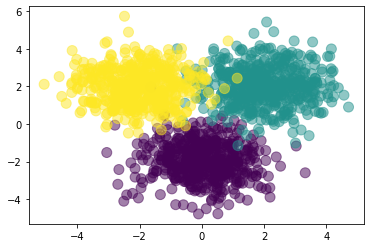

In [ ]:
#Creating training data. Setting the random seed so the data is somewhat different from the test data
np.random.seed(1)

# generate three Gaussian clouds each holding 500 points
X1 = np.random.randn(500, 2) + np.array([0, -2])
X2 = np.random.randn(500, 2) + np.array([2, 2])
X3 = np.random.randn(500, 2) + np.array([-2, 2])

# put them all in a big matrix
X_train = np.vstack([X1, X2, X3])

# generate the one-hot-encodings
labels = np.array([0]*500 + [1]*500 + [2]*500)
T_train = np.zeros((1500, 3))
for i in range(1500):
    T_train[i, labels[i]] = 1

# visualize the data
plt.scatter(X_train[:,0], X_train[:,1], c=labels, s=100, alpha=0.5)
plt.show()

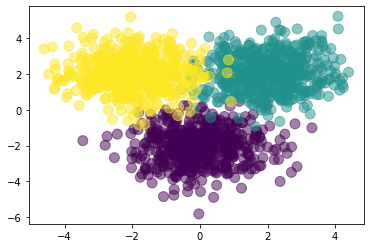

In [ ]:
#Generating test data with a different random seed
np.random.seed(50)

# generate three Gaussian clouds each holding 500 points
X1 = np.random.randn(500, 2) + np.array([0, -2])
X2 = np.random.randn(500, 2) + np.array([2, 2])
X3 = np.random.randn(500, 2) + np.array([-2, 2])

# put them all in a big matrix
X_test = np.vstack([X1, X2, X3])

# generate the one-hot-encodings
labels = np.array([0]*500 + [1]*500 + [2]*500)
T_test = np.zeros((1500, 3))
for i in range(1500):
    T_test[i, labels[i]] = 1

# visualize the data
plt.scatter(X_test[:,0], X_test[:,1], c=labels, s=100, alpha=0.5)
plt.show()

In [ ]:
#Creating the neural network. It is important to note that the previous layer parameter matches the size of the last layer. 
#As you can see the syntax looks quite similar to the Keras syntax.

#Creating our layers. The sizes here are somewhat arbitary
input_layer = InputLayer(2)
hidden1 = DenseLayer(20, 2, sigmoid)
hidden2 = DenseLayer(100, 20, sigmoid)
hidden3 = DenseLayer(20, 100, sigmoid)
output = DenseLayer(3, 20, softmax)

#Adding the layers into the sequential model
model = Sequential()
model.add(input_layer)
model.add(hidden1)
model.add(hidden2)
model.add(hidden3)
model.add(output)

In [ ]:
#Training the model and finding losses.
losses = model.fit(X_train, T_train)

Epoch: 0  Loss: 3.6936148895627605
Epoch: 100  Loss: 2.592965747449266
Epoch: 200  Loss: 1.5279871077208953
Epoch: 300  Loss: 0.8699536609870433
Epoch: 400  Loss: 0.6699709264017241
Epoch: 500  Loss: 0.504973790960484
Epoch: 600  Loss: 0.4631602378885706
Epoch: 700  Loss: 0.4383926361533419
Epoch: 800  Loss: 0.419920648691691
Epoch: 900  Loss: 0.4054394843325003
Epoch: 1000  Loss: 0.39429493736173205
Epoch: 1100  Loss: 0.38583170860464616
Epoch: 1200  Loss: 0.379267668484092
Epoch: 1300  Loss: 0.3739696253999047
Epoch: 1400  Loss: 0.36951852977289174
Epoch: 1500  Loss: 0.36565140086157616
Epoch: 1600  Loss: 0.36219992410701735
Epoch: 1700  Loss: 0.35905057712540145
Epoch: 1800  Loss: 0.35612116127990556
Epoch: 1900  Loss: 0.35334675621400974


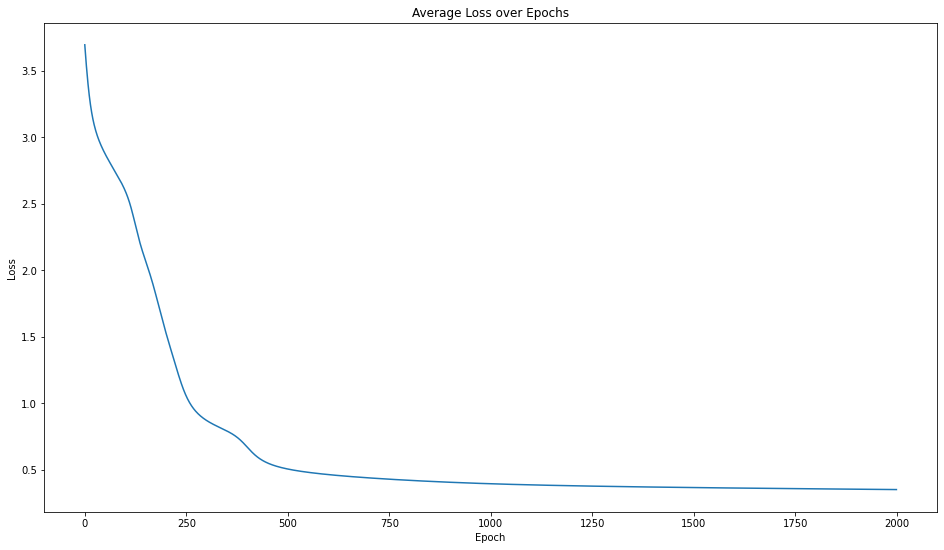

In [ ]:
#Plotting the losses
plt.figure(figsize=(16, 9))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Average Loss over Epochs')
plt.show()

In [ ]:
#Making predictions over both the training data and the test data
y_pred_train, training_loss = model.predict(X_train, T_train)
y_pred_test, test_loss = model.predict(X_test, T_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:182: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:195: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [ ]:
#Training and test data loss. Surprisingly the model performs better on the test data
print('Training loss:', training_loss)
print('Test loss:', test_loss)

Training loss: 0.35067058887991975
Test loss: 0.3488911800174731


In [ ]:
#Calculating the accuracy
training_accuracy = 1 - (np.sum(abs(T_train - y_pred_train))/2)/len(T_train)
test_accuracy = 1 - (np.sum(abs(T_test - y_pred_test))/2)/len(T_test)

In [ ]:
print('Training Accuracy:', training_accuracy)
print('Test Accuracy:', test_accuracy)

Training Accuracy: 0.9473333333333334
Test Accuracy: 0.952


## Testing with the MNIST Dataset

Now we will test the model on the MNIST dataset.

In [ ]:
#Importing the data
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
#Preprocessing the training data. This can probably be done cleaner.
flattened_x = []

#We flatten the pictures into a list
for i in range(len(x_train)):
  flattened_x.append(x_train[i].flatten())

flattened_x = np.array(flattened_x)

#I only take the first 5000 observations for training.
flattened_x = flattened_x[:5000]

#We do one hot encoding for the y values, so they have a vector with 1 for the actual value and zeros for everything else 
onehotys = np.zeros((len(y_train), 10))

for i in range(len(onehotys)):
  onehotys[i][y_train[i]] = 1

onehotys = onehotys[:5000]



In [ ]:
#preprocessing the test data. Doing the same thing we did for the training data

flattened_x_test = []

for i in range(len(x_test)):
  flattened_x_test.append(x_test[i].flatten())

flattened_x_test = np.array(flattened_x_test)

flattened_x_test = flattened_x_test[:1000]

onehoty_test = np.zeros((len(y_test), 10))

for i in range(len(onehoty_test)):
  onehoty_test[i][y_test[i]] = 1

onehoty_test = onehoty_test[:1000]

Text(0.5, 1.0, '5')

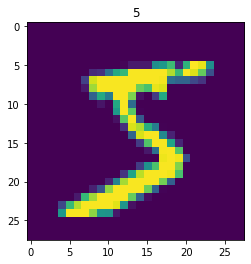

In [ ]:
#Plotting a couple of digits
plt.imshow(x_train[0])
plt.title(y_train[0])

Text(0.5, 1.0, '0')

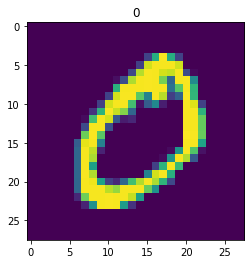

In [ ]:
plt.imshow(x_train[1])
plt.title(y_train[1])

In [ ]:
#Building the network.

#We need 784 as the input size as the flattened pictures have that many entries. For the output we have 10 nodes (1 for each category)
input_layer = InputLayer(784)
hidden1 = DenseLayer(20, 784, sigmoid)
hidden2 = DenseLayer(50, 20, sigmoid)
hidden3 = DenseLayer(20, 50, sigmoid)
output = DenseLayer(10, 20, softmax)

#Putting the model together
model = Sequential(learning_rate=0.2)
model.add(input_layer)
model.add(hidden1)
model.add(hidden2)
model.add(hidden3)
model.add(output)

In [ ]:
#Training the model. This takes very long with epoch=5000
mnist_losses = model.fit(flattened_x, onehotys, epochs=5000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in power
  


Epoch: 0  Loss: 5.673848534109858
Epoch: 100  Loss: 2.2441568132175695
Epoch: 200  Loss: 2.0851084414722867
Epoch: 300  Loss: 1.9786476744329027
Epoch: 400  Loss: 1.8887565700501703
Epoch: 500  Loss: 1.8329183210747584
Epoch: 600  Loss: 1.7911309881049606
Epoch: 700  Loss: 1.7582779365778483
Epoch: 800  Loss: 1.7314861217341595
Epoch: 900  Loss: 1.7075749788297403
Epoch: 1000  Loss: 1.6846656539199854
Epoch: 1100  Loss: 1.658288320139225
Epoch: 1200  Loss: 1.6345548608684406
Epoch: 1300  Loss: 1.6164285037937112
Epoch: 1400  Loss: 1.5973246684106268
Epoch: 1500  Loss: 1.5823134061145452
Epoch: 1600  Loss: 1.5682097785017253
Epoch: 1700  Loss: 1.5509906976840866
Epoch: 1800  Loss: 1.537081447308656
Epoch: 1900  Loss: 1.5253087605992848
Epoch: 2000  Loss: 1.507020171061128
Epoch: 2100  Loss: 1.4892246061401833
Epoch: 2200  Loss: 1.4785003940408767
Epoch: 2300  Loss: 1.4585128737137638
Epoch: 2400  Loss: 1.4364133364089073
Epoch: 2500  Loss: 1.4242689705174074
Epoch: 2600  Loss: 1.4118537

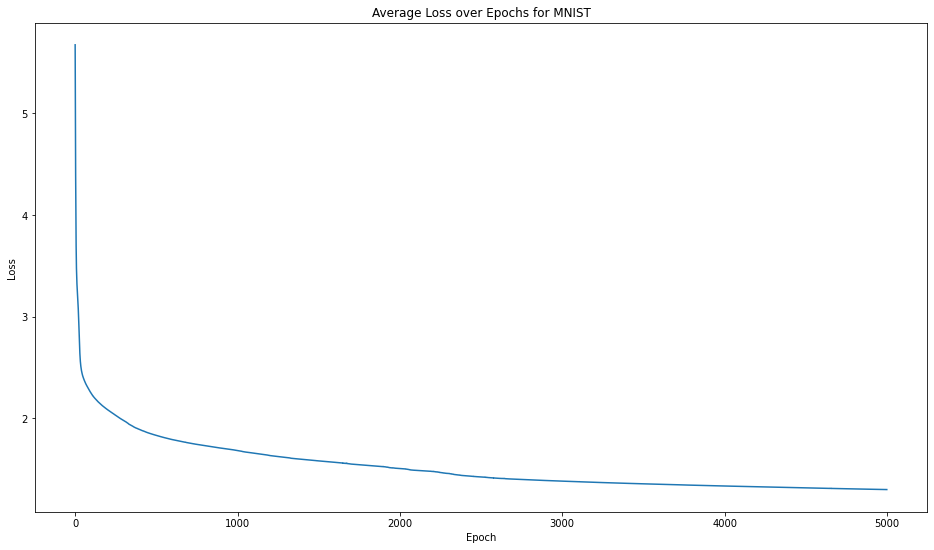

In [ ]:
#Plotting the losses

plt.figure(figsize=(16, 9))
plt.plot(mnist_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Average Loss over Epochs for MNIST')
plt.show()

In [ ]:
#making predictions
y_pred, loss = model.predict(flattened_x_test, onehoty_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in power
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:182: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:195: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [ ]:
print('Test set loss:', loss)

Test set loss: 1.5478591525329466


In [ ]:
#The accuracy of the model
mnist_accuracy = 1 - (np.sum(abs(onehoty_test - y_pred))/2)/len(onehoty_test)
print('Test accuracy of the model', mnist_accuracy)

Test accuracy of the model 0.479


Now you might ask me if I am joking. An accuracy that is worse than 50%!!??!?!
But we have to acknowledge that there are 10 categories to be classified and a random guess would have only guessed correct 10% of the time on average. Therefore, this is actually quite good of an improvement. However, that's not to say that the model is perfect. We can make many improvements to the model.

Maybe one of the biggest flaws of this experiment is that we're trying to do image classification from input vectors of numbers and such a practice will of course have its own limitations. A next step could be implementing convolutional and pooling layer classes as well so that we can start detecting visual patterns instead of chasing numerical relationships in the training data.

Another improvement that is rather easy to implement is having adaptable batch sizes. Now, the batch size is by default equal to the whole training data set, therefore, updates to the weights and biases are only done once the whole dataset is passed through the model. This gives us an average of the loss but doesn't allow finer tuning for specific examples. Implementing this would only require having another loop for the fit() where every loop would run the optimization on a smaller part of the data. 



## Runtime Analysis

Here I compare the runtime for different input sizes. For all of the observations, I set the epoch to 1, because increasing the epoch repeats the same operation, but it is linear to the input size.

In [ ]:
#Loading the full training set
(full_sized_x, full_sized_y), (_, _) = mnist.load_data()

In [ ]:
#Preprocessing
flattened_x_full = []

#We flatten the pictures into a list
for i in range(len(x_train)):
  flattened_x_full.append(full_sized_x[i].flatten())

flattened_x_full = np.array(flattened_x_full)

#We do one hot encoding for the y values, so they have a vector with 1 for the actual value and zeros for everything else 
onehotysfull = np.zeros((len(full_sized_y), 10))

for i in range(len(onehotysfull)):
  onehotysfull[i][full_sized_y[i]] = 1

In [ ]:
#Using the same model as above
input_layer = InputLayer(784)
hidden1 = DenseLayer(20, 784, sigmoid)
hidden2 = DenseLayer(50, 20, sigmoid)
hidden3 = DenseLayer(20, 50, sigmoid)
output = DenseLayer(10, 20, softmax)

#Putting the model together
model = Sequential(learning_rate=0.2)
model.add(input_layer)
model.add(hidden1)
model.add(hidden2)
model.add(hidden3)
model.add(output)

In [ ]:
#Looping for different input sizes and recording the input size and the runtime
import time 
runtimes=[]
input_size=[]

for n in range(2, 60000, 50):
  input_size.append(n)
  start_time=time.time()
  model.fit(flattened_x_full[:n], onehotysfull[:n], epochs=1)
  end_time=time.time()

  runtimes.append(end_time-start_time)

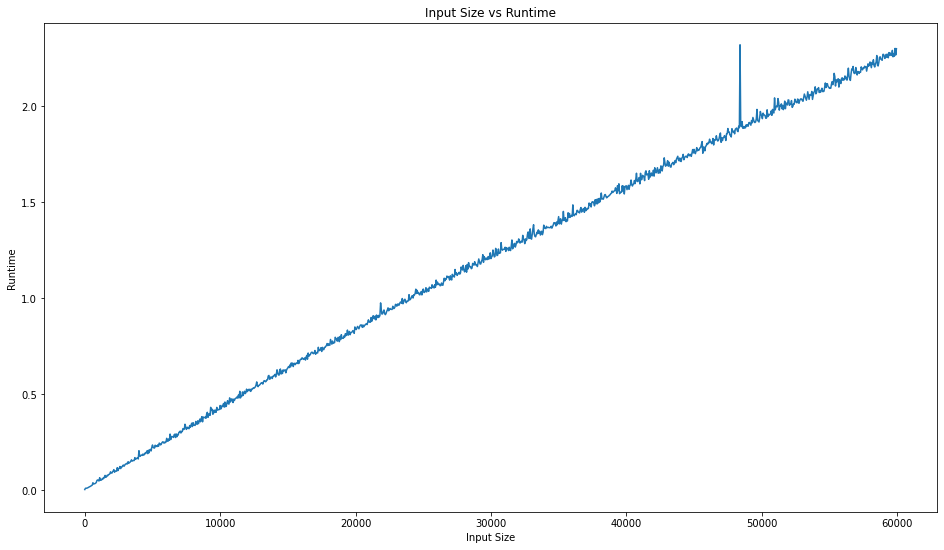

In [ ]:
#Plotting
plt.figure(figsize=(16, 9))
plt.plot(input_size, runtimes)
plt.xlabel('Input Size')
plt.ylabel('Runtime')
plt.title('Input Size vs Runtime')
plt.show()


Looking at the runtime graph we can see that our model also has a runtime that is somewhat linear [O(n)] to the input size (Potential Extension: implement a neural network to do not only classifications but also regression and estimate the function plotted above :)). This is quite interesting to see since technically the matrix operations should have had a high runtime as looping around a matrices (for both the inputs and weights) is needed to perform the operations we do. According to this source (https://kasperfred.com/series/introduction-to-neural-networks/computational-complexity-of-neural-networks) the computational complexity of backpropogation is sopposed to be O(n^5). However, throughout the whole process the number of weights (or adjustable parameters) within the system is fixed. Furthermore, the functions in numpy are optimized to avoid looping over the inputs and instead perform matrix operations in fixed time and also using the GPU support in Cocalc further speeds up the whole process by an insane amount. Nonetheless, seeing this as an actual result is quite amazing. This also shows us that our network is working in a quite optimized manner.

## A Few Final Words

In this notebook I implemented a neural network from scratch using the numpy package only and tried to walk you through the steps of my decision making and understanding of the whole process as much as possible. The final product is not perfect, but is indeed a working neural network that is capable of being trained and making predictions on categorical data. It has room for improvement by implementing things such as working with different batch sizes, different kinds of layers, different optimizers and different activation functions. Also, practices such as weight decay or dropout can be further inprovements. I think a very important strength of my implementation is that the abstraction is done in a very intuitive manner and therefore the implementation is very easy while allowing a lot of freedom for the user in terms of the network architecture. Also, you might notice that the actual code for the network classes is rather short and this is because it is coded in an efficient, ebject-oriented manner. The performance of the model is also good as can be seen from the linear runtime with respect to the input size. This is thanks to using the numpy arrays and built-in functions, which are in a lot of cases compiled into C and other lower level languages that reduce the costs of the loops. 



Sources: I used this source to familiarize myself with backpropogation and the derivative of the softmax with cross entropy loss better and followed their algorithmic steps. I highly recommend it: http://www.adeveloperdiary.com/data-science/deep-learning/neural-network-with-softmax-in-python/